## Training the Model

### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU


### Image Preprocessing

Constants

In [2]:
image_size = 50
batch_size = 32
epochs = 20  # We use EarlyStopping, so it might stop earlier

train_dir = r'breastcancerdataset/train'
test_dir = r'breastcancerdataset/test'

Data Generators

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 222019 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


### Convert to tf.data Pipeline with Cache and Prefetch

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32))
).unbatch().batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32))
).unbatch().batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

### CNN Model Architecture

In [5]:

model = Sequential([
# Input Layer 
    Input(shape=(image_size, image_size, 3)),

# First Conv Block
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),

# Second Conv Block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),

# Third Conv Block
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    MaxPooling2D(pool_size=(2, 2)),

# Flatten & Fully Connected Layers
    Flatten(),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.5),

# Output Layer for Binary Classification
    Dense(1, activation='sigmoid')
])

### Compile the Model

In [6]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,329 (4.86 MB)

 Trainable params: 1,274,369 (4.86 MB)

 Non-trainable params: 960 (3.75 KB)

### Early Stopping

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

### Train the Model

In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

c:\Users\sohil\anaconda3\envs\AICourse\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 2002s 288ms/step - accuracy: 0.8435 - loss: 0.3675 - val_accuracy: 0.8058 - val_loss: 0.6423
Epoch 2/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 509s 73ms/step - accuracy: 0.8689 - loss: 0.3099 - val_accuracy: 0.8498 - val_loss: 0.3456
Epoch 3/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 496s 72ms/step - accuracy: 0.8749 - loss: 0.2959 - val_accuracy: 0.8539 - val_loss: 0.3437
Epoch 4/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 497s 72ms/step - accuracy: 0.8831 - loss: 0.2795 - val_accuracy: 0.8516 - val_loss: 0.5036
Epoch 5/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 501s 72ms/step - accuracy: 0.8884 - loss: 0.2695 - val_accuracy: 0.8437 - val_loss: 0.3855
Epoch 6/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 505s 73ms/step - accuracy: 0.8908 - loss: 0.2597 - val_accuracy: 0.8525 - val_loss: 0.3313
Epoch 7/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 508s 73ms/step - accuracy: 0.8951 - loss: 0.2505 - val_accuracy: 0.8838 - val_loss: 0.2797
Epoch 8/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 518s 75ms/step - accuracy

### Plot Accuracy & Loss

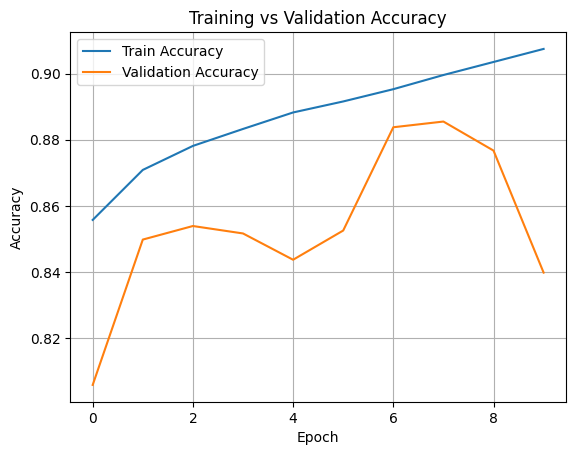

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Save the Model

In [ ]:
model.save(r"Flask/breastcancer.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!
